<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/VariationalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

Check MultivariateNormal

In [2]:
from torch.distributions import MultivariateNormal

mean = torch.tensor([0.0259, 0.0057])
logvar = torch.tensor([ 0.0084, -0.0500])
var = torch.exp(logvar)
print(var)
print(torch.diag(var))
mvn = MultivariateNormal(mean, torch.diag(var))

sample = mvn.sample()
print(f'sample: {sample}')

tensor([1.0084, 0.9512])
tensor([[1.0084, 0.0000],
        [0.0000, 0.9512]])
sample: tensor([ 1.5734, -0.2805])


In [62]:
device = 'cuda' if torch.accelerator.is_available() else 'cpu'
latent_dimension = 16
print(device)

cuda


In [4]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.5kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.33MB/s]


In [5]:
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True)

In [6]:
test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor())

test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=True)

In [7]:
def get_sample(codings):
  mean, logvar = codings
  var = torch.exp(logvar)
  cov = torch.diag_embed(var)
  dist = torch.distributions.MultivariateNormal(mean, cov)
  return dist.rsample()



In [8]:
class VariationalEncoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalEncoderV1, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.mean_base = nn.Sequential(
            nn.Linear(256, 392),
            nn.ReLU(),
            nn.Linear(392, latent_dim)
        )

        self.variance_base = nn.Sequential(
            nn.Linear(256, 392),
            nn.ReLU(),
            nn.Linear(392, latent_dim)
        )



    def forward(self, x):
            x= self.first(x)
            x= F.relu(x)
            x = x.reshape((-1, 256))
            mu = self.mean_base(x) # mu for the latent image data distribution
            logvar = self.variance_base(x) # assuming this is log of variation , as we will later optimize on the exponential value of this,
            x = get_sample((mu, logvar)) # we will be passing the sample generated from mu and sigma , not original image
            return x, mu, logvar

In [9]:
encoded, mu, logvar = VariationalEncoderV1(latent_dimension)(torch.randn(1,1,28,28))

In [60]:
class VariationalDecoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalDecoderV1, self).__init__()
        self.first = nn.Sequential(
            nn.Linear(latent_dim, 392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x= self.first(x)
        decoded = x
        return decoded.reshape((-1, 1, 28, 28))


In [11]:
decoded = VariationalDecoderV1(latent_dimension)(encoded)

In [50]:
def custom_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # comaperes two distribution

    return reproduction_loss + KLD

In [64]:
enc = VariationalEncoderV1(latent_dimension)
dec = VariationalDecoderV1(latent_dimension)

In [65]:
class VariationalAutoEncoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoEncoderV1, self).__init__()
        self.encoder = enc
        self.decoder = dec

    def forward(self, x):
        encoded, mu, logvar = self.encoder(x)
        decoded = self.decoder(encoded) # we are using only the sample generated from mu and sigma , not original image
        return decoded, mu, logvar


In [66]:
def train(model, data, epochs=15):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
    model.to(device)
    model.train()
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)

            opt.zero_grad()
            x_hat, mu, logvar = model(x)
            loss = custom_loss_function(x, x_hat, mu, logvar)

            loss.backward()
            opt.step()
        print(f'epoch: {epoch} , loss: {loss}')
    return model, mu, logvar

In [67]:
latent_dims = 16
variational_autoencoder_model = VariationalAutoEncoderV1(latent_dimension).to(device)
autoencoder, mu, logvar = train(variational_autoencoder_model, train_dataloader)
torch.save({'mu': mu, 'logvar': logvar}, 'vae_params.pt')  # just save the mu and sigma for future use

epoch: 0 , loss: 1296.4256591796875
epoch: 1 , loss: 1119.590087890625
epoch: 2 , loss: 1167.74658203125
epoch: 3 , loss: 1083.6307373046875
epoch: 4 , loss: 1139.31591796875
epoch: 5 , loss: 1070.530029296875
epoch: 6 , loss: 983.240478515625
epoch: 7 , loss: 988.052001953125
epoch: 8 , loss: 989.4619140625
epoch: 9 , loss: 887.970947265625
epoch: 10 , loss: 952.737060546875
epoch: 11 , loss: 1018.6785888671875
epoch: 12 , loss: 841.8548583984375
epoch: 13 , loss: 1012.229736328125
epoch: 14 , loss: 903.5296630859375


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

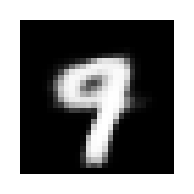

In [84]:
vae_params = torch.load('vae_params.pt')
mu = vae_params['mu'].to(device)
logvar = vae_params['logvar'].to(device)

sampled_data = get_sample((mu, logvar))  # generated sample from saved  mu and sigma

generated= variational_autoencoder_model.decoder(sampled_data.to(device)) # use the decoder from trained model to generate new data from sample

fig, axes = plt.subplots(1, 1, figsize=(3, 1))
axes.imshow(generated[0].cpu().detach().numpy().squeeze(), cmap='gray')
axes.axis('off')

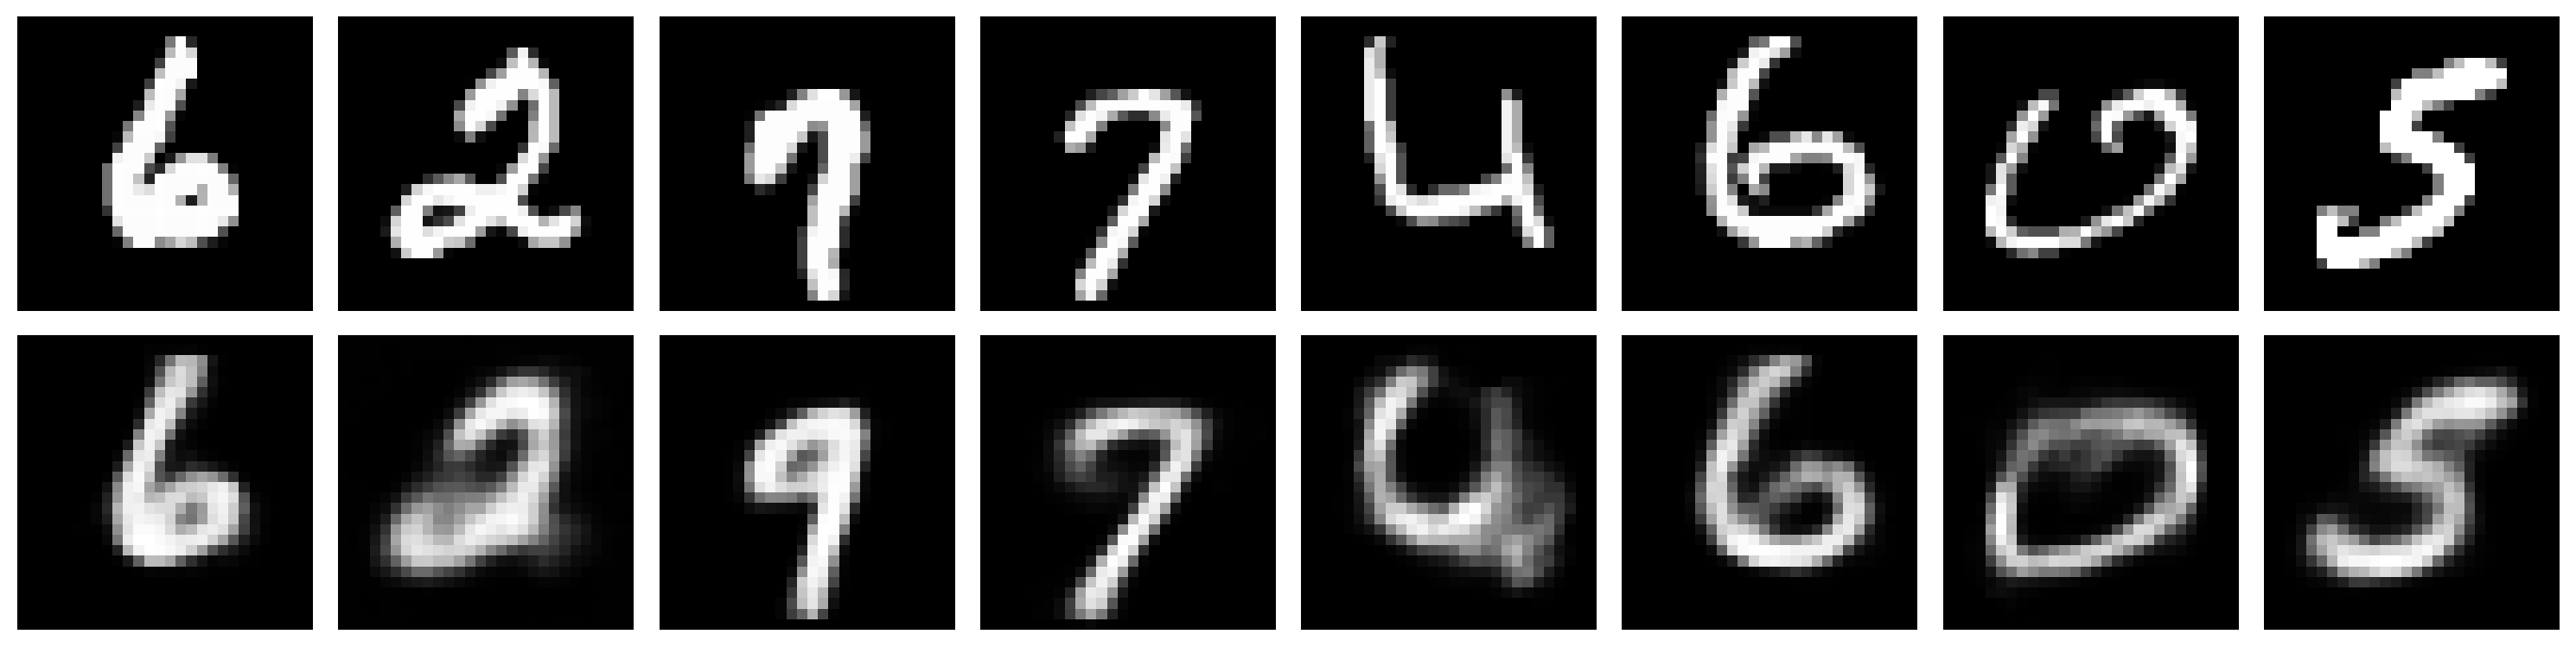

In [85]:
def visualize_rebuild(model, data_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed,_,_ = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()

# Visualize results
visualize_rebuild(variational_autoencoder_model, test_dataloader)